In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import signal
import pathlib
import itertools
import glob
import json

In [2]:
import monalysa
from monalysa import movements
from monalysa import quality

In [3]:
# Define the font family and size
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['font.weight'] = 'light'  # Use 'light' font weight

In [4]:
base_fig_dir = pathlib.Path.cwd().parent / "figures"

## Demonstration of limits of sequences of movements

In [28]:
def twosub_move(a1, a2, tstrt1, tstrt2, tstp1, tstp2, T, dt):
    """Generates a movement with two submovements with the given amplitudes,
    start times and stop times."""
    t = np.arange(0, T, dt)
    if tstrt1 < tstp1: 
        _T1 = tstp1 - tstrt1
        m1 = movements.mjt_discrete_movement(a1, dur=_T1, 
                                             loc=0.5 * (tstp1 + tstrt1),
                                             time=t)
        m1 = (np.power(_T1, 3) / 60) * m1
    else:
        m1 = np.zeros(t.shape)
    if tstrt2 < tstp2:
        _T2 = tstp2 - tstrt2
        m2 = movements.mjt_discrete_movement(a2, dur=_T2, 
                                             loc=0.5 * (tstp2 + tstrt2),
                                             time=t)
        m2 = (np.power(_T2, 3) / 60) * m2
    else:
        m2 = np.zeros(t.shape)
    return t, m1 + m2

In [29]:
def moveindicator(m, th=0):
    """A movement indicator function that returns 1 if there is a movement
    as defined by the threshold th, and 0 otherwise."""
    return (m > th).astype(int)

def moveint(m, th, dt):
    """A movement interval function that returns the temporal interval of the 
    given movement."""
    _mi = np.where(moveindicator(m, th) == 1)[0]
    return (np.min(_mi) - 1) * dt, (np.max(_mi) + 1) * dt

def movedur(m, th, dt):
    """A movement duration function that returns the duration of the given 
    movement."""
    return moveint(m, th, dt)[1] - moveint(m, th, dt)[0]

In [30]:
def stdist(move1, move2, th, dt):
    """Computes the spatio-temporal distance between two movements.
    """
    # Movement durations for the two movements
    dur1 = movedur(move1, 0, dt)
    dur2 = movedur(move2, 0, dt)
    # Spatial distance
    _sdist = np.linalg.norm(move1 - move2, ord=2) * dt
    # spatial weight
    ws = 1 / ((np.linalg.norm(move1, ord=2) + np.linalg.norm(move2, ord=2)) * dt)
    # Temporal distance
    _tdist = np.abs(dur1 - dur2)
    # temporal weight
    wt = 1 / (dur1 + dur2)
    return ws * _sdist + wt * _tdist

### Changing amplitude, fixed temporal parameters

In [39]:
T = 2.0
dt = 0.001
time = np.arange(0, T, dt)
T = 1
# Reference movement
move_ref = (np.power(T, 3) / 60) * movements.mjt_discrete_movement(1, dur=T, loc=0.5, time=time)

In [40]:
# Generate the squence of movements
a2 = 1/ np.arange(1, 1000)
move1_k = [twosub_move(a1=1, a2=_a2, tstrt1=0., tstrt2=1.,
                       tstp1=1., tstp2=2, T=2, dt=0.001)[1] for _a2 in a2]

### Changing start time, fixed amplitude and duration

In [56]:
tstrt2 = 2 - 1 / np.arange(1, 1000)
# Generate the squence of movements
move2_k = [twosub_move(a1=1, a2=2 - _ts, tstrt1=0., tstrt2=_ts,
                       tstp1=1., tstp2=2, T=2, dt=0.001)[1] for _ts in tstrt2]

### Changing duration, fixed amplitude and start time

In [57]:
tstp2 = 1 + 1/ np.arange(1, 1000)
# Generate the squence of movements
move3_k = [twosub_move(a1=1, a2=_ts - 1, tstrt1=0., tstrt2=1.0,
                       tstp1=1., tstp2=_ts, T=2, dt=0.001)[1] for _ts in tstp2]

In [60]:
# Compute spatio-temporal distances
stdist1 = [stdist(move_ref, _m, 0, dt) for _m in move1_k]
stdist2 = [stdist(move_ref, _m, 0, dt) for _m in move2_k]
stdist3 = [stdist(move_ref, _m, 0, dt) for _m in move3_k]

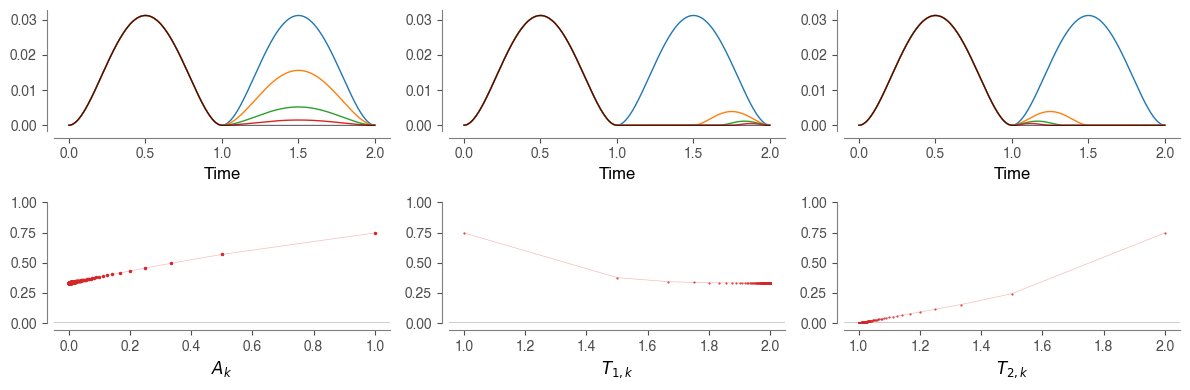

In [63]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(231)
ax.plot(time, move1_k[0], lw=1)
ax.plot(time, move1_k[1], lw=1)
ax.plot(time, move1_k[5], lw=1)
ax.plot(time, move1_k[20], lw=1)
ax.plot(time, move_ref, 'k', lw=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
# ax.set_ylim(-0.1, 2)
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.set_xlabel("Time", fontsize=12)

ax = fig.add_subplot(232)
ax.plot(time, move2_k[0], lw=1)
ax.plot(time, move2_k[1], lw=1)
ax.plot(time, move2_k[2], lw=1)
ax.plot(time, move2_k[3], lw=1)
ax.plot(time, move_ref, 'k', lw=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
# ax.set_ylim(-0.1, 2)
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.set_xlabel("Time", fontsize=12)

ax = fig.add_subplot(233)
ax.plot(time, move3_k[0], lw=1)
ax.plot(time, move3_k[1], lw=1)
ax.plot(time, move3_k[2], lw=1)
ax.plot(time, move3_k[3], lw=1)
ax.plot(time, move_ref, 'k', lw=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
# ax.set_ylim(-0.1, 2)
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.set_xlabel("Time", fontsize=12)

ax = fig.add_subplot(234)
ax.plot(a2[:-2], stdist1[:-2], lw=0.5, alpha=0.3, color="tab:red")
ax.plot(a2[:-2], stdist1[:-2], ".", markersize=3, color="tab:red")
ax.axhline(0, color='0.0', lw=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.set_ylim(0.0, 1.0)
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.set_xlabel(r"$A_{k}$", fontsize=12)

ax = fig.add_subplot(235)
ax.axhline(0, color='0.0', lw=1)
ax.plot(tstrt2[:-2], stdist2[:-2], lw=0.5, alpha=0.3, color="tab:red")
ax.plot(tstrt2[:-2], stdist2[:-2], ".", markersize=1, color="tab:red")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.set_ylim(0.0, 1.0)
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.set_xlabel(r"$T_{1,k}$", fontsize=12)

ax = fig.add_subplot(236)
ax.axhline(0, color='0.0', lw=1)
ax.plot(tstp2[:-2], stdist3[:-2], lw=0.5, alpha=0.3, color="tab:red")
ax.plot(tstp2[:-2], stdist3[:-2], ".", markersize=1, color="tab:red")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.set_ylim(0.0, 1.0)
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.set_xlabel(r"$T_{2, k}$", fontsize=12)

plt.tight_layout()

# Save figure
# fig.savefig(pathlib.Path(base_fig_dir, f"move_seq_connvrg.pdf"), bbox_inches="tight")
# fig.savefig(pathlib.Path(base_fig_dir, f"move_seq_connvrg.svg"), bbox_inches="tight")

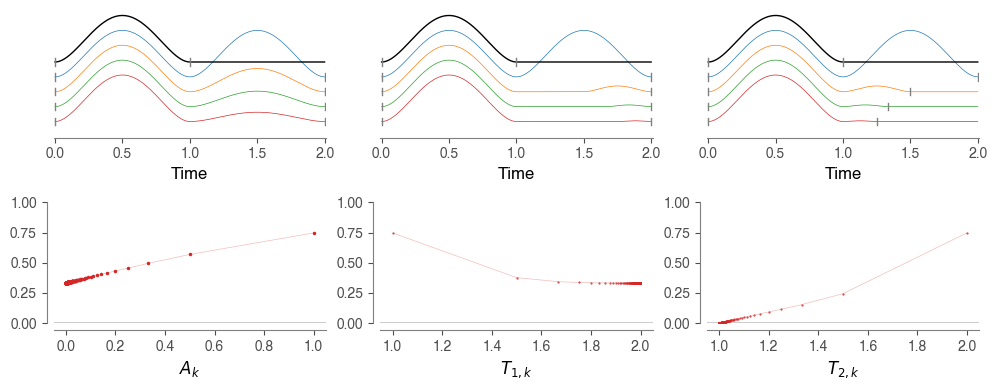

In [99]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(231)
dy = -0.01
ax.plot(time, 1 * dy + move1_k[0], lw=0.5)
ax.plot(time, 2 * dy + move1_k[1], lw=0.5)
ax.plot(time, 3 * dy + move1_k[2], lw=0.5)
ax.plot(time, 4 * dy + move1_k[4], lw=0.5)
ax.plot(time, move_ref, 'k', lw=1)
# Start/Stop times
_strtx, _strty = np.array([0, 0]), np.array([-0.0025, 0.0025])
ax.plot(_strtx, _strty, color="0.5", lw=1)
ax.plot(_strtx, 1 * dy + _strty, color="0.5", lw=1)
ax.plot(_strtx, 2 * dy + _strty, color="0.5", lw=1)
ax.plot(_strtx, 3 * dy + _strty, color="0.5", lw=1)
ax.plot(_strtx, 4 * dy + _strty, color="0.5", lw=1)
ax.plot([1, 1], _strty, color="0.5", lw=1)
ax.plot([2, 2], 1 * dy + _strty, color="0.5", lw=1)
ax.plot([2, 2], 2 * dy + _strty, color="0.5", lw=1)
ax.plot([2, 2], 3 * dy + _strty, color="0.5", lw=1)
ax.plot([2, 2], 4 * dy + _strty, color="0.5", lw=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.set_yticks([])
ax.set_xlim(-0.01, 2.01)
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.set_xlabel("Time", fontsize=12)

ax = fig.add_subplot(232)
ax.plot(time, 1 * dy + move2_k[0], lw=0.5)
ax.plot(time, 2 * dy + move2_k[1], lw=0.5)
ax.plot(time, 3 * dy + move2_k[2], lw=0.5)
ax.plot(time, 4 * dy + move2_k[3], lw=0.5)
ax.plot(time, move_ref, 'k', lw=1)
# Start/Stop times
_strtx, _strty = np.array([0, 0]), np.array([-0.0025, 0.0025])
ax.plot(_strtx, _strty, color="0.5", lw=1)
ax.plot(_strtx, 1 * dy + _strty, color="0.5", lw=1)
ax.plot(_strtx, 2 * dy + _strty, color="0.5", lw=1)
ax.plot(_strtx, 3 * dy + _strty, color="0.5", lw=1)
ax.plot(_strtx, 4 * dy + _strty, color="0.5", lw=1)
ax.plot([1, 1], _strty, color="0.5", lw=1)
ax.plot([2, 2], 1 * dy + _strty, color="0.5", lw=1)
ax.plot([2, 2], 2 * dy + _strty, color="0.5", lw=1)
ax.plot([2, 2], 3 * dy + _strty, color="0.5", lw=1)
ax.plot([2, 2], 4 * dy + _strty, color="0.5", lw=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.set_yticks([])
ax.set_xlim(-0.01, 2.01)
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.set_xlabel("Time", fontsize=12)

ax = fig.add_subplot(233)
ax.plot(time, 1 * dy + move3_k[0], lw=0.5)
ax.plot(time, 2 * dy + move3_k[1], lw=0.5)
ax.plot(time, 3 * dy + move3_k[2], lw=0.5)
ax.plot(time, 4 * dy + move3_k[3], lw=0.5)
ax.plot(time, move_ref, 'k', lw=1)
# Start/Stop times
_strtx, _strty = np.array([0, 0]), np.array([-0.0025, 0.0025])
ax.plot(_strtx, _strty, color="0.5", lw=1)
ax.plot(_strtx, 1 * dy + _strty, color="0.5", lw=1)
ax.plot(_strtx, 2 * dy + _strty, color="0.5", lw=1)
ax.plot(_strtx, 3 * dy + _strty, color="0.5", lw=1)
ax.plot(_strtx, 4 * dy + _strty, color="0.5", lw=1)
ax.plot([1, 1], _strty, color="0.5", lw=1)
ax.plot([2, 2], 1 * dy + _strty, color="0.5", lw=1)
ax.plot([1.5, 1.5], 2 * dy + _strty, color="0.5", lw=1)
ax.plot([1.33, 1.33], 3 * dy + _strty, color="0.5", lw=1)
ax.plot([1.25, 1.25], 4 * dy + _strty, color="0.5", lw=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.set_yticks([])
ax.set_xlim(-0.01, 2.01)
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.set_xlabel("Time", fontsize=12)

ax = fig.add_subplot(234)
ax.plot(a2[:-2], stdist1[:-2], lw=0.5, alpha=0.3, color="tab:red")
ax.plot(a2[:-2], stdist1[:-2], ".", markersize=3, color="tab:red")
ax.axhline(0, color='0.0', lw=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.set_ylim(0.0, 1.0)
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.set_xlabel(r"$A_{k}$", fontsize=12)

ax = fig.add_subplot(235)
ax.axhline(0, color='0.0', lw=1)
ax.plot(tstrt2[:-2], stdist2[:-2], lw=0.5, alpha=0.3, color="tab:red")
ax.plot(tstrt2[:-2], stdist2[:-2], ".", markersize=1, color="tab:red")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.set_ylim(0.0, 1.0)
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.set_xlabel(r"$T_{1,k}$", fontsize=12)

ax = fig.add_subplot(236)
ax.axhline(0, color='0.0', lw=1)
ax.plot(tstp2[:-2], stdist3[:-2], lw=0.5, alpha=0.3, color="tab:red")
ax.plot(tstp2[:-2], stdist3[:-2], ".", markersize=1, color="tab:red")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.set_ylim(0.0, 1.0)
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.set_xlabel(r"$T_{2, k}$", fontsize=12)

plt.tight_layout()

# Save figure
fig.savefig(pathlib.Path(base_fig_dir, f"move_seq_connvrg.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(base_fig_dir, f"move_seq_connvrg.svg"), bbox_inches="tight")